In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 26))
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(30, grid_bounds=[(0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

model = GPClassificationModel()
model.condition(train_x, train_y)

GPClassificationModel (
  (likelihood): BernoulliLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (covar_module): RBFKernel (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 100))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

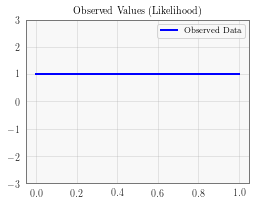

In [6]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [7]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = model.forward(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

/home/gpleiss/Dropbox/workspace/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/200 - Loss: 127912.406   log_lengthscale: 0.000
Iter 2/200 - Loss: 100612.055   log_lengthscale: -0.100
Iter 3/200 - Loss: 64037.938   log_lengthscale: -0.200
Iter 4/200 - Loss: 49977.234   log_lengthscale: -0.297
Iter 5/200 - Loss: 45381.445   log_lengthscale: -0.393
Iter 6/200 - Loss: 32202.734   log_lengthscale: -0.491
Iter 7/200 - Loss: 20132.205   log_lengthscale: -0.589
Iter 8/200 - Loss: 23793.986   log_lengthscale: -0.686
Iter 9/200 - Loss: 17897.691   log_lengthscale: -0.784
Iter 10/200 - Loss: 12219.517   log_lengthscale: -0.883
Iter 11/200 - Loss: 10798.681   log_lengthscale: -0.982
Iter 12/200 - Loss: 8816.522   log_lengthscale: -1.081
Iter 13/200 - Loss: 8084.330   log_lengthscale: -1.181
Iter 14/200 - Loss: 5907.943   log_lengthscale: -1.281
Iter 15/200 - Loss: 6907.569   log_lengthscale: -1.376
Iter 16/200 - Loss: 4988.991   log_lengthscale: -1.476
Iter 17/200 - Loss: 4413.563   log_lengthscale: -1.576
Iter 18/200 - Loss: 4034.611   log_lengthscale: -1.678
Iter 19

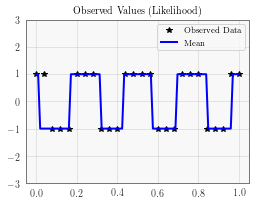

In [8]:
f = plot_model_and_predictions(model)